In [1]:
#first we are going to plot both the dcm's
#NOTE: the AX-VIBRANT series is pre contrast and PH1/AX VIBRANT series is post contrast
#using slice #42

In [10]:
#importing necessary modules
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2

Plotting slice 42 of both pre and post contrast

In [17]:

def read_dicom(file_path):
    dicom_data = pydicom.dcmread(file_path)
    return dicom_data.pixel_array



def plot_dicom(pre, post):
    # Read the DICOM files
    dicom1 = pydicom.dcmread(pre)
    dicom2 = pydicom.dcmread(post)

    # Extract the image data
    image1 = dicom1.pixel_array
    image2 = dicom2.pixel_array

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the first image
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title('PreContrast slice 42')
    axes[0].axis('off')  # Hide the axes

    # Plot the second image
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title('PostContrast slice 42')
    axes[1].axis('off')  # Hide the axes

    # Display the plots
    plt.show()

Applying the function

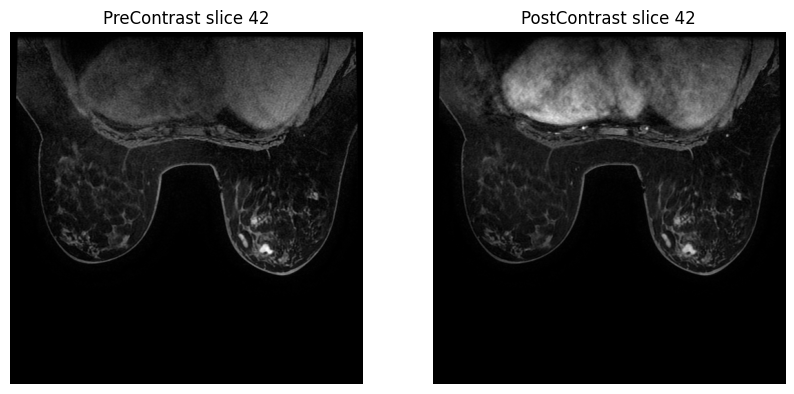

In [6]:
pre_path = 'data/manifest-1722210581008/ISPY2/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/500.000000-ISPY2 AX VIBRANT-SERIES-52523/1-042.dcm'
post_path = 'data/manifest-1722210581008/ISPY2/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/501.000000-ISPY2 Ph1AX VIBRANT-SERIES-03969/1-042.dcm'

plot_dicom(pre_path,post_path)

Validation of pixel orientation of two slices

In [7]:


def compare_dicom_orientation(pre, post):
    # Read the DICOM files
    dicom1 = pydicom.dcmread(pre)
    dicom2 = pydicom.dcmread(post)

    # Extract the relevant attributes
    attributes = [
        ('Image Position (Patient)', 'ImagePositionPatient', (0x0020, 0x0032)),
        ('Image Orientation (Patient)', 'ImageOrientationPatient', (0x0020, 0x0037)),
        ('Pixel Spacing', 'PixelSpacing', (0x0028, 0x0030)),
        ('Slice Thickness', 'SliceThickness', (0x0018, 0x0050)),
        ('Slice Location', 'SliceLocation', (0x0020, 0x1041))
    ]

    for attr_name, attr_key, tag in attributes:
        value1 = dicom1.get(tag, 'Not Found')
        value2 = dicom2.get(tag, 'Not Found')
        print(f"{attr_name}:")
        print(f"  File 1: {value1}")
        print(f"  File 2: {value2}")
        print()

# Example usage:
# Replace 'path_to_dicom1.dcm' and 'path_to_dicom2.dcm' with the actual file paths
compare_dicom_orientation(pre_path, post_path)


Image Position (Patient):
  File 1: (0020, 0032) Image Position (Patient)            DS: [180.394, 138.539, -23]
  File 2: (0020, 0032) Image Position (Patient)            DS: [180.394, 138.539, -23]

Image Orientation (Patient):
  File 1: (0020, 0037) Image Orientation (Patient)         DS: [-1, -0, 0, -0, -1, 0]
  File 2: (0020, 0037) Image Orientation (Patient)         DS: [-1, -0, 0, -0, -1, 0]

Pixel Spacing:
  File 1: (0028, 0030) Pixel Spacing                       DS: [0.6641, 0.6641]
  File 2: (0028, 0030) Pixel Spacing                       DS: [0.6641, 0.6641]

Slice Thickness:
  File 1: (0018, 0050) Slice Thickness                     DS: '2.0'
  File 2: (0018, 0050) Slice Thickness                     DS: '2.0'

Slice Location:
  File 1: (0020, 1041) Slice Location                      DS: '-23.0'
  File 2: (0020, 1041) Slice Location                      DS: '-23.0'



As the images have perfect orientation, we can move on to the Subtraction

In [19]:


def align_images(image1, image2):
    """Align two images using ECC (Enhanced Correlation Coefficient) algorithm."""
    # Convert images to float32
    image1_float = image1.astype(np.float32)
    image2_float = image2.astype(np.float32)
    
    # Find size of image1
    size = image1.shape

    # Define the motion model
    warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Define the number of iterations and termination criteria
    number_of_iterations = 5000
    termination_eps = 1e-10

    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations, termination_eps)

    # Run the ECC algorithm to find the warp matrix
    (cc, warp_matrix) = cv2.findTransformECC(image1_float, image2_float, warp_matrix, cv2.MOTION_TRANSLATION, criteria)

    # Use warpAffine for Translation
    image2_aligned = cv2.warpAffine(image2_float, warp_matrix, (size[1], size[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

    return image2_aligned

def subtract_images(image1, image2):
    """Subtract two images."""
    return image1 - image2

def display_image(image, title="Image"):
    """Display an image using matplotlib."""
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


All 3 images side by side

(-0.5, 511.5, 511.5, -0.5)

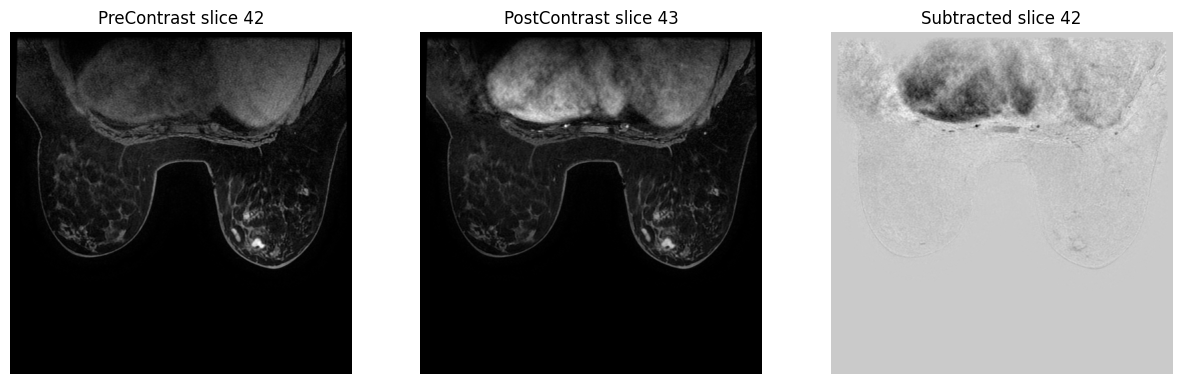

In [23]:
# Align the images
image2_aligned = align_images(read_dicom(pre_path), read_dicom(post_path))

# Subtract the images
subtracted_image = subtract_images(read_dicom(pre_path), image2_aligned)

    # Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Read the DICOM files
dicom1 = pydicom.dcmread(pre_path)
dicom2 = pydicom.dcmread(post_path)


    # Extract the image data
image1 = dicom1.pixel_array
image2 = dicom2.pixel_array

    # Plot the first image
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('PreContrast slice 42')
axes[0].axis('off')  # Hide the axes

    # Plot the second image
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('PostContrast slice 43')
axes[1].axis('off')  # Hide the axes

    # Plot the third image
axes[2].imshow(subtracted_image, cmap='gray')
axes[2].set_title('Subtracted slice 42')
axes[2].axis('off')  # Hide the axes



In [ ]:

def plot_three_dicom_images(file_path1, file_path2, file_path3):
    # Read the DICOM files
    dicom1 = pydicom.dcmread(file_path1)
    dicom2 = pydicom.dcmread(file_path2)
    dicom3 = pydicom.dcmread(file_path3)

    # Extract the image data
    image1 = dicom1.pixel_array
    image2 = dicom2.pixel_array
    image3 = dicom3.pixel_array

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first image
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title('DICOM Image 1')
    axes[0].axis('off')  # Hide the axes

    # Plot the second image
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title('DICOM Image 2')
    axes[1].axis('off')  # Hide the axes

    # Plot the third image
    axes[2].imshow(image3, cmap='gray')
    axes[2].set_title('DICOM Image 3')
    axes[2].axis('off')  # Hide the axes

    # Display the plots
    plt.show()

# Example usage:
# Replace 'image1.dcm', 'image2.dcm', and 'image3.dcm' with the actual file paths
plot_three_dicom_images('image1.dcm', 'image2.dcm', 'image3.dcm')
